# Implementing authorless topic models

This is my attempt to implement [Thompson & Mimno 2018.](http://www.cs.cornell.edu/~laurejt/papers/authorless-tms-2018.pdf)

In [13]:
import sys, csv, math, random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr
from scipy.stats import gamma
from collections import Counter

In [5]:
rv = gamma(3., loc = 0., scale = 2.)

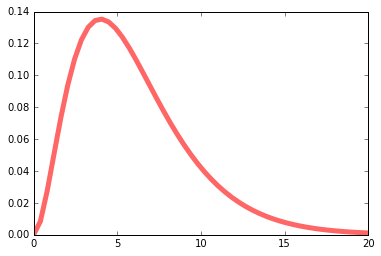

In [8]:
fig, ax = plt.subplots()
x = np.linspace(0, 20)
ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='gamma pdf')
plt.show()

In [9]:
meta = pd.read_csv('../../metadata/filtered_fiction_plus_18c.tsv', sep = '\t', index_col = 'docid')
meta = meta[~meta.index.duplicated(keep = 'first')]

In [124]:
authorvocab = dict()

with open('/Users/tunder/data/character_table_18c19c.tsv', encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        docid = fields[0]
        if docid not in meta.index:
            continue
        author = meta.loc[docid, 'author']
        if author not in authorvocab:
            authorvocab[author] = Counter()
        words = fields[5].split()
        for w in words:
            authorvocab[author][w] += 1

with open('/Users/tunder/data/character_table_post1900.tsv', encoding = 'utf-8') as f:
    for line in f:
        fields = line.strip().split('\t')
        docid = fields[0]
        if docid not in meta.index:
            continue
        author = meta.loc[docid, 'author']
        if author not in authorvocab:
            authorvocab[author] = Counter()
        words = fields[5].split()
        for w in words:
            authorvocab[author][w] += 1

In [128]:
allwords = Counter()
ctr = 0
for author, vocab in authorvocab.items():
    allwords = allwords + vocab
    ctr += 1
    if ctr % 10 == 1:
        print(ctr)
lexicon = [x[0] for x in allwords.most_common()]
print(len(lexicon))

1
11
21
31


KeyboardInterrupt: 

In [130]:
allwords = Counter()
ctr = 0
for author, vocab in authorvocab.items():
    ctr += 1
    if ctr % 100 == 1:
        print(ctr)
    for w in vocab.keys():
        allwords[w] += 1
print(len(allwords))

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401
4501
4601
4701
4801
4901
5001
5101
5201
5301
5401
5501
5601
5701
5801
5901
6001
6101
6201
6301
6401
6501
6601
6701
6801
6901
7001
7101
7201
7301
7401
7501
7601
7701
7801
7901
8001
8101
8201
8301
8401
8501
8601
8701
8801
8901
9001
9101
9201
9301
9401
9501
9601
9701
9801
9901
10001
10101
10201
10301
10401
10501
10601
10701
10801
10901
11001
11101
11201
11301
11401
11501
11601
11701
11801
11901
12001
12101
12201
12301
12401
12501
12601
12701
12801
12901
13001
13101
13201
13301
13401
13501
13601
13701
13801
13901
14001
14101
14201
14301
14401
14501
14601
14701
14801
14901
15001
15101
15201
15301
15401
15501
15601
15701
15801
15901
16001
16101
16201
16301
16401
16501
16601
16701
16801
16901
17001
17101
17201
17301
17401
17501
17601
17701
17801
17901
18001
18101
18201
18301
18401
18

In [144]:
lexicon = allwords.most_common()
lexicon = [x for x in lexicon if x[1] > 20]
print(len(lexicon))

144689


In [145]:
with open('../dataprep/ficlexicon.tsv', mode = 'w', encoding = 'utf-8') as f:
    f.write('word\tnumauthors\n')
    for word, authfreq in lexicon:
        f.write(word + '\t' + str(authfreq) + '\n')

In [146]:
authsums = dict()
for author, vocab in authorvocab.items():
    authsum = sum(vocab.values())
    authsums[author] = authsum

In [148]:
lexicon[0:10]

[('said', 39089),
 ('had', 38899),
 ('was', 38623),
 ('went', 37809),
 ('took', 37772),
 ('came', 37759),
 ('eyes', 37644),
 ('head', 37536),
 ('made', 37459),
 ('face', 37257)]

In [149]:
authorstops = dict()
ctr = 0

for word, authfreq in lexicon:
    ctr += 1
    if ctr % 100 == 1:
        print(ctr)
        
    vector = []
    authors = []
    for author, vocab in authorvocab.items():
        authsum = authsums[author]
        if authsum > 0:
            authors.append(author)
            vector.append(vocab[word] / authsum)
    vector = np.array(vector)

    variance = np.std(vector) ** 2
    mean = np.mean(vector)

    k = (mean ** 2) / variance
    theta = variance / mean
    g = gamma(k, loc = 0., scale = theta)
    threshold = g.ppf(0.95)
    for auth, freq in zip(authors, vector):
        if freq > threshold:
            stopprob = 1 - (threshold / freq)
            if stopprob > 0:
                if auth not in authorstops:
                    authorstops[auth] = []
                authorstops[auth].append((stopprob, word))

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401
4501
4601
4701
4801
4901
5001
5101
5201
5301
5401
5501
5601
5701
5801
5901
6001
6101
6201
6301
6401
6501
6601
6701
6801
6901
7001
7101
7201
7301
7401
7501
7601
7701
7801
7901
8001
8101
8201
8301
8401
8501
8601
8701
8801
8901
9001
9101
9201
9301
9401
9501
9601
9701
9801
9901
10001
10101
10201
10301
10401
10501
10601
10701
10801
10901
11001
11101
11201
11301
11401
11501
11601
11701
11801
11901
12001
12101
12201
12301
12401
12501
12601
12701
12801
12901
13001
13101
13201
13301
13401
13501
13601
13701
13801
13901
14001
14101
14201
14301
14401
14501
14601
14701
14801
14901
15001
15101
15201
15301
15401
15501
15601
15701
15801
15901
16001
16101
16201
16301
16401
16501
16601
16701
16801
16901
17001
17101
17201
17301
17401
17501
17601
17701
17801
17901
18001
18101
18201
18301
18401
18

132901
133001
133101
133201
133301
133401
133501
133601
133701
133801
133901
134001
134101
134201
134301
134401
134501
134601
134701
134801
134901
135001
135101
135201
135301
135401
135501
135601
135701
135801
135901
136001
136101
136201
136301
136401
136501
136601
136701
136801
136901
137001
137101
137201
137301
137401
137501
137601
137701
137801
137901
138001
138101
138201
138301
138401
138501
138601
138701
138801
138901
139001
139101
139201
139301
139401
139501
139601
139701
139801
139901
140001
140101
140201
140301
140401
140501
140601
140701
140801
140901
141001
141101
141201
141301
141401
141501
141601
141701
141801
141901
142001
142101
142201
142301
142401
142501
142601
142701
142801
142901
143001
143101
143201
143301
143401
143501
143601
143701
143801
143901
144001
144101
144201
144301
144401
144501
144601


In [153]:
with open('../dataprep/authorless.tsv', mode = 'w', encoding = 'utf-8') as f:
    f.write('author\tword\tstopprob\n')
    for author, tuplelist in authorstops.items():
        for stopprob, word in tuplelist:
            f.write(str(author) + '\t' + word + '\t' + str(stopprob) + '\n')

In [152]:
author

nan

In [143]:
ct = 0
for k, v in authorstops.items():
    ct += 1
    if ct > 10:
        break
    print(k, v)

Desai, Boman. [(0.25812059078187333, 'head'), (0.36124520869418231, 'spoke'), (0.50755219098273274, 'smiled'), (0.48517158923900439, 'laughed')]
Telscombe, Anne. [(0.17834276121710135, 'had'), (0.1086797513108867, 'found'), (0.20616687730415972, 'heard'), (0.042133055897579208, 'began'), (0.038352625613586877, 'tried'), (0.34091142637881378, 'seemed')]
Dunne, Pete, [(0.2416786566184429, 'seemed')]
White, Rhoda Elizabeth Waterman. [(0.18660491535557633, 'heart')]
(Ira Louis), Reeves, Ira L. [(0.16919331565533602, 'turned'), (0.025528334218409277, 'arms'), (0.11961160162823903, 'seen'), (0.1583436599149296, 'name'), (0.53305207028913459, 'started'), (0.15929981725992315, 'wife'), (0.11369323706187862, 'returned'), (0.10866951786498835, 'man'), (0.20785453793872999, 'get'), (0.29537418719153619, 'reached')]
Lintz, Gertrude Davies. [(0.13405276694877699, 'had'), (0.067256592505715362, 'was'), (0.21479634621471644, 'life'), (0.19344237466209036, 'kept'), (0.1502592073336626, 'take'), (0.200

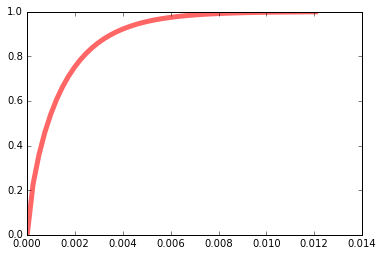

In [119]:
rv = gamma(k, loc = 0., scale = theta)
fig, ax = plt.subplots()
x = np.linspace(0, rv.ppf(.999))
ax.plot(x, rv.cdf(x), 'r-', lw=5, alpha=0.6, label='gamma pdf')
plt.show()

In [122]:
threshold = gamma.ppf(0.94, a = k, loc = 0., scale = theta)
threshold

0.0044703025067474146

In [123]:
ctr = 0
for author, vocab in authorvocab.items():
    authsum = sum(vocab.values())
    if authsum > 0:
        hathfreq = vocab[word] / authsum
        if hathfreq > threshold:
            # print(author, hathfreq)
            ctr += 1
print(ctr, ctr / len(authors))

233 0.040346320346320345


In [71]:
len(authors)

5775

In [107]:
rv.ppf(.99)

0.0058971533739358376